In [11]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [12]:
# load training and test datasets
train_raw = pd.read_csv('input/train_set.csv', parse_dates=[2,])
test_raw = pd.read_csv('input/test_set.csv', parse_dates=[3,])

In [35]:
#set up a data for ols
ols_data = train_raw.copy()
ols_data['year'] = train_raw.quote_date.dt.year

#set up a point to test
index = 7
point = dict(ols_data[['annual_usage','min_order_quantity', 'bracket_pricing',
                       'quantity','year','supplier']].loc[index])


print(point)
print(ols_data['cost'].loc[index])

{'annual_usage': 0, 'min_order_quantity': 0, 'bracket_pricing': 'Yes', 'quantity': 250, 'year': 2013, 'supplier': 'S-0066'}
2.99905966403855


RMSE: 235.18554687853967, R2: 0.13593217758830634, params: 61
quantity coeff -0.05821136351386409
AIC: 284215.8746188102
nobs > 100: 2385 mean error: 4.109373225428738


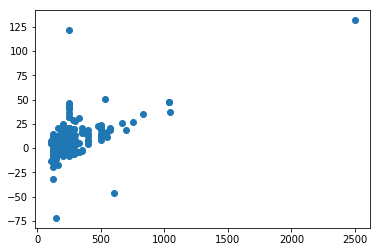

In [68]:
def print_model_summary(model, data, log=False):
    print('RMSE: %s, R2: %s, params: %s'%(model.mse_model**.5, model.rsquared, model.params.shape[0]-1))
    if not log:
        print('quantity coeff %s'%model.params['quantity'])
    else:
        print('quantity coeff %s'%model.params['np.log(quantity)'])
    print('AIC: %s'% model.aic)
    quantity = np.concatenate(([data['quantity']],[model.resid]),axis=0)
    quantity = quantity.transpose()
    quantity = quantity[ (quantity[:,0] > 100) ]
    print('nobs > 100:', quantity.shape[0], 'mean error:', quantity[:,1].mean())
    plt.scatter(quantity[:,0], quantity[:,1])
        


#regular model
baseline_ols = smf.ols('cost ~  1 + quantity + annual_usage + min_order_quantity + bracket_pricing + \
                       year + supplier', data = ols_data)
baseline_fit = baseline_ols.fit()

#summarize
print_model_summary(baseline_fit, ols_data)

RMSE: 14.044690349091029, R2: 0.4663250744329087, params: 61
quantity coeff -0.3506106311382903
AIC: 62124.58394707255
nobs > 100: 2385 mean error: 0.3040550283837025


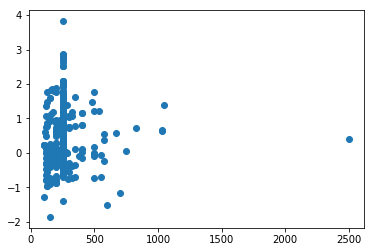

In [69]:
#log model
logs_ols = smf.ols('np.log(cost) ~ 1 + np.log(quantity) + annual_usage +  min_order_quantity + bracket_pricing  + \
+ year + supplier', data = ols_data)
logs_fit = logs_ols.fit()

#summarize
print_model_summary(logs_fit, ols_data, log=True)

RMSE: 11.760802157991938, R2: 0.4931696160353297, params: 117
quantity coeff -0.23038955723491156
AIC: 60627.275887895616
nobs > 100: 2385 mean error: 0.34668904871967526
<F test: F=array([[87.01626171]]), p=0.0, df_denom=30120, df_num=60>


/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 61, but rank is 60
  'rank is %d' % (J, J_), ValueWarning)


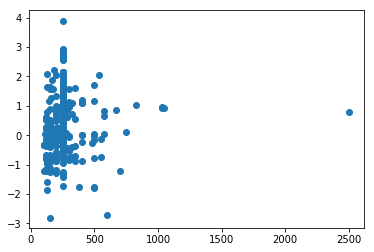

In [70]:
squaredterm_ols = smf.ols('np.log(cost) ~  1 + np.log(quantity) + annual_usage +  min_order_quantity + bracket_pricing  + \
                        supplier + year + supplier*np.log(quantity) ', data = ols_data)
squaredterm_fit = squaredterm_ols.fit()

#summarize
print_model_summary(squaredterm_fit,ols_data, log=True )

#run an f-test (might be wrong?)
base_params = len(baseline_fit.params)
restrict = len(squaredterm_fit.params)

A = np.identity(restrict)
A = A[:base_params-1,:]
print(squaredterm_fit.f_test(A))

In [71]:
def print_tree_stats(model, data, labels, log=False):
    #set up point
    xgdata = xgb.DMatrix(data.copy(), label=labels)
    mse = ( ( xgdata.get_label() - model.predict(xgdata) )**2).sum()
    r2 = 1 - mse/(( xgdata.get_label() - xgdata.get_label().mean() )**2).sum()
    dim = data.shape[1]
    
    print('RMSE: %s, R2: %s, params: %s'%(mse**.5,r2,dim))

    
#setup baseline tree data
tree_data = ols_data.copy()[['annual_usage', 'min_order_quantity','bracket_pricing','quantity','year']]
tree_data['bracket_pricing'] = (tree_data['bracket_pricing'] == 'Yes')

#supplier dummies
supplier_dum = pd.get_dummies(ols_data['supplier'], drop_first=True)
tree_data = np.concatenate((tree_data,supplier_dum),axis=1)

#labels
labels = np.array(ols_data['cost'])

In [73]:
# fit a random forest model
params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["min_child_weight"] = 5
params["subsample"] = 1.0
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 7
plst = list(params.items())
num_rounds = 120


xgtrain = xgb.DMatrix(tree_data, label=labels)
xgmodel = xgb.train(plst, xgtrain, num_rounds)
print_tree_stats(xgmodel,tree_data, labels)

RMSE: 2697.3765958797817, R2: 0.7068740129470825, params: 61


RMSE: 2697.3765958797817, R2: 0.7068740129470825, params: 61
nobs > 100: 2385 mean error: 0.09346090003084588


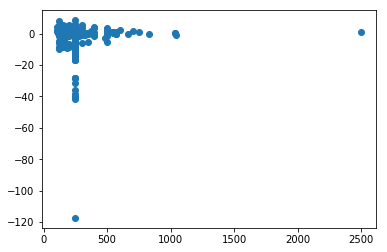

In [85]:
def print_tree_stats(model, data, labels, log=False):
    #set up point
    xgdata = xgb.DMatrix(data.copy(), label=labels)
    fitted_y = model.predict(xgdata)
    mse = ( ( xgdata.get_label() - fitted_y )**2).sum()
    r2 = 1 - mse/(( xgdata.get_label() - xgdata.get_label().mean() )**2).sum()
    dim = data.shape[1]
    print('RMSE: %s, R2: %s, params: %s'%(mse**.5,r2,dim))
    
    quantity =  np.array(data[:,3],dtype=np.float32)
    if log is not False:
        quantity = np.exp(quantity)
    quantity = np.concatenate(([quantity] ,[fitted_y-labels]),axis=0)
    quantity = quantity.transpose()
    quantity = quantity[ (quantity[:,0] > 100) ]
    print('nobs > 100:', quantity.shape[0], 'mean error:', quantity[:,1].mean())
    plt.scatter(quantity[:,0], quantity[:,1])
    
    

print_tree_stats(xgmodel,tree_data, labels)

RMSE: 73.61499825952589, R2: 0.7899768501520157, params: 61
nobs > 100: 4737 mean error: 0.0028785242487456204


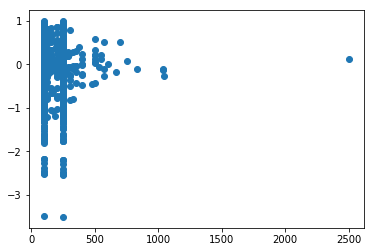

In [86]:
log_quant = np.array(tree_data[:,3],dtype=np.float32)
log_quant = np.log(log_quant)
log_tree_data = tree_data.copy()
log_tree_data[:,3] = log_quant

log_labels = np.log(labels)
log_xgtrain = xgb.DMatrix(log_tree_data, label=log_labels)


log_xgmodel = xgb.train(plst, log_xgtrain , num_rounds)
print_tree_stats(log_xgmodel,log_tree_data,log_labels,log=True)